In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, \
make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
def fail_recall(y_true,y_pred):
    """
    uses sklearn.metrics.recall_score() to return the recall score of
    non functioning wells.
    Takes single column array or dataframe of true labels
    and one of predictions 
    returns recall score of class 0.
    """
    
    return recall_score(y_true,y_pred,average=None)[0]

recaller = make_scorer(fail_recall)

## Drop the irrelevant columns, 

In [3]:
df = pd.read_csv('content/regs_with_activity_stats.csv')
df.drop(columns = ['id_student','code_module','code_presentation','module_presentation_length',
                  'total_days_studied'], inplace = True)
df.loc[df['final_result'] == 'Withdrawn', 'final_result'] = 'Fail'
df.loc[df['final_result'] == 'Distinction', 'final_result'] = 'Pass'
df.head()

,gender,highest_education,age_band,num_of_prev_attempts,disability,final_result,date_registration,avg_daily_activities,mean_clicks_per_day,pct_days_studied
0,M,HE Qualification,55<=,0,N,Pass,-159.0,4.695652,25.521739,0.255556
1,F,HE Qualification,35-55,0,N,Pass,-53.0,6.388889,22.805556,0.400000
2,F,A Level or Equivalent,35-55,0,N,Pass,-52.0,5.803922,19.450980,0.566667
3,F,Lower Than A Level,0-35,0,N,Pass,-176.0,5.400000,19.542857,0.388889
4,M,A Level or Equivalent,35-55,0,N,Pass,-110.0,5.206897,18.275862,0.644444


## Preprocessing

In [4]:
X = df.drop(columns = ['final_result'])
y = df['final_result']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=111, test_size=0.2)

In [5]:
encoder.classes_

array(['Fail', 'Pass'], dtype=object)

In [6]:
categoricals = X.select_dtypes(include = 'object').columns
numericals = X.select_dtypes(include = 'number').columns
transformers = [('ohe', OneHotEncoder(sparse = False, drop= 'first'), categoricals),
                 ('scaler', StandardScaler(), numericals)]
col_transformer = ColumnTransformer(transformers = transformers)

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

# Other Models

### Logistic Regression

In [20]:
params = [{'model__solver':['liblinear'], 'model__tol':[1e-4,1e-5],
           'model__class_weight':['balanced',None],'model__max_iter':[500,1000]},
          {'model__solver':['sag','saga','newton-cg'], 'model__tol':[1e-4,1e-5],
           'model__class_weight':['balanced',None],'model__max_iter':[500,1000],
          'model__penalty':['none', 'l2']}]

LRpipeline = Pipeline(steps = [('processor', col_transformer),
                             ('model', LogisticRegression(class_weight='balanced'))])

LRclf = GridSearchCV(LRpipeline, params, scoring = 'accuracy', cv = cv)

LRclf.fit(X_train,y_train.reshape(-1,))

print('best params', LRclf.best_params_)
print('mean_test_scores', LRclf.best_score_)

best params {'model__class_weight': None, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 0.0001}
mean_test_scores 0.7008791760864105


              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1936
           1       0.71      0.83      0.77      3041

    accuracy                           0.69      4977
   macro avg       0.68      0.65      0.66      4977
weighted avg       0.68      0.69      0.68      4977



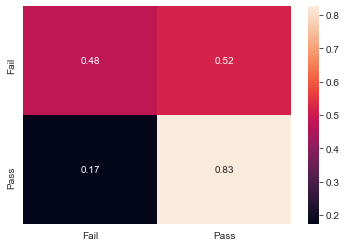

In [21]:
y_pred = LRclf.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'),
           xticklabels = encoder.classes_,
           yticklabels = encoder.classes_,
           annot = True)

### Gaussian Naive Bayes

In [14]:
GNBpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', GaussianNB())])
GNBscores = cross_val_score(GNBpipeline, X_train, y_train,
                        scoring = recaller,
                        cv = cv,
                        n_jobs = -1)
GNBscores

array([0.60025221, 0.64190094, 0.57151899, 0.60496311, 0.64572539])

### Decision Tree

In [15]:
DTpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', DecisionTreeClassifier())])
DTscores = cross_val_score(DTpipeline, X_train, y_train,
                        scoring = 'accuracy',
                        cv = cv,
                        n_jobs = -1)
DTscores

array([0.60462195, 0.61366491, 0.60010048, 0.61215775, 0.60612911])

In [17]:
params = {'model__criterion':['gini','entropy'],'model__splitter':['best','random'],
         'model__max_depth':[5,10,20]}

DTclf = GridSearchCV(DTpipeline, params, cv = cv)

### Random Forest

In [ ]:
RFpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', RandomForestClassifier())])
RFscores = cross_val_score(RFpipeline, X_train, y_train,
                        scoring = 'accuracy',
                        cv = cv,
                        n_jobs = -1)
RFscores

In [ ]:
RFpipeline.fit(X_train,y_train)
y_pred = RFpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = RFpipeline.classes_)

In [ ]:
DTpipeline.fit(X_train,y_train)
y_pred = DTpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = DTpipeline.classes_)

In [ ]:
GNBpipeline.fit(X_train,y_train)
y_pred = GNBpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = GNBpipeline.classes_)

In [ ]:
LRpipeline.fit(X_train,y_train)
y_pred = LRpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = LRpipeline.classes_)

# GridSearch

In [ ]:
pipeline.coef_

In [ ]:
LR = pipeline.named_steps['model']
CT = pipeline.named_steps['processing']

In [ ]:

pd.DataFrame(LR.coef_)

In [ ]:
X_train_3

Let's try a GridSearch